In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Indices de los puntos clave de los labios
index_lips = [61, 185, 40, 39, 37, 0, 
              146, 91, 181, 84, 17,
              267, 269, 270, 409, 291,
              314, 405, 321, 375] # Representan el borde de los labios
index_eyes = [33, 263] # Representan el centro del ojo izquierdo

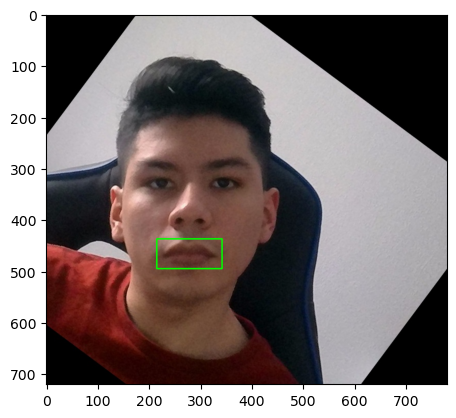

In [7]:
# Cargar el modelo de Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Función para extraer el rectángulo que contiene los labios
def extract_lips_rectangle(image_path):
    lip_info = []
    lip_rect = None

    image = cv2.imread(image_path)
    
    # Procesar la imagen con Face Mesh
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    # Verificar si se detectaron puntos clave
    if results.multi_face_landmarks:
        # Obtener los puntos clave de los labios
        face_landmarks = results.multi_face_landmarks[0]
        for idx in index_lips:
            lip_info.append([face_landmarks.landmark[idx].x * image.shape[1], 
                             face_landmarks.landmark[idx].y * image.shape[0]])
        
        # Calcular el rectángulo que contiene los puntos clave de los labios
        x_min = int(min(point[0] for point in lip_info)) 
        y_min = int(min(point[1] for point in lip_info)) 
        x_max = int(max(point[0] for point in lip_info)) 
        y_max = int(max(point[1] for point in lip_info)) 

        box_length_x_margin = int(((x_max - x_min)/100)*20) #Calculamos el 10% de la longitud x de la caja que contiene la boca
        box_length_y_margin = int(((y_max - y_min)/100)*20)

        x_min = x_min - box_length_x_margin
        y_min = y_min - box_length_y_margin
        x_max = x_max + box_length_x_margin 
        y_max = y_max + box_length_y_margin
        
        lip_rect = (x_min, y_min, x_max, y_max)
    
    return lip_rect

# Ejemplo de uso
image = cv2.imread('img_Memoria/Imatge_alineada.jpg')
lip_rect = extract_lips_rectangle('img_Memoria/Imatge_alineada.jpg')

if lip_rect is not None:
    # Dibujar el rectángulo en la imagen
    cv2.rectangle(image, (lip_rect[0], lip_rect[1]), (lip_rect[2], lip_rect[3]), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
else:
    print("No se detectaron labios en la imagen.")


In [8]:
imagen_grande = cv2.imread('img_Memoria/Imatge_alineada.jpg')
cuadrado = imagen_grande[lip_rect[1]:lip_rect[3], lip_rect[0]:lip_rect[2]]

In [9]:
cuadrado.shape

(58, 127, 3)

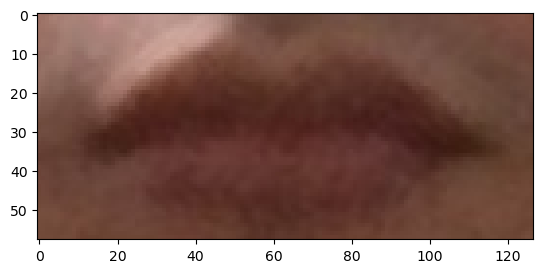

In [10]:
plt.imshow(cv2.cvtColor(cuadrado, cv2.COLOR_BGR2RGB))

(50, 100, 3)


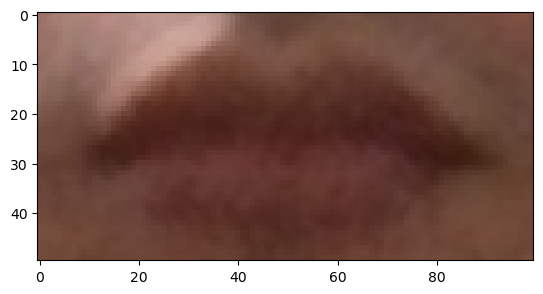

In [11]:
imagen_redimensionada = cv2.resize(cuadrado, (100, 50), interpolation=cv2.INTER_AREA)
print(imagen_redimensionada.shape)
plt.imshow(cv2.cvtColor(imagen_redimensionada, cv2.COLOR_BGR2RGB))

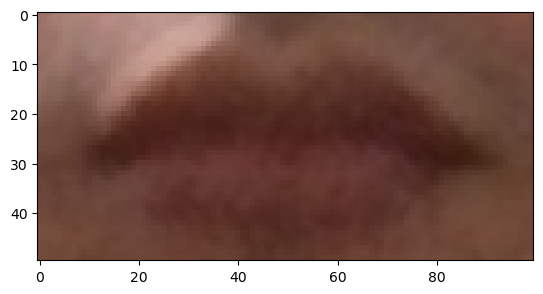

In [13]:
imagen_normalizada = imagen_redimensionada.astype('float32')
imagen_normalizada /= 255.0
plt.imshow(cv2.cvtColor(imagen_normalizada, cv2.COLOR_BGR2RGB))

Text(0.5, 1.0, 'Requadre Normalitzat')

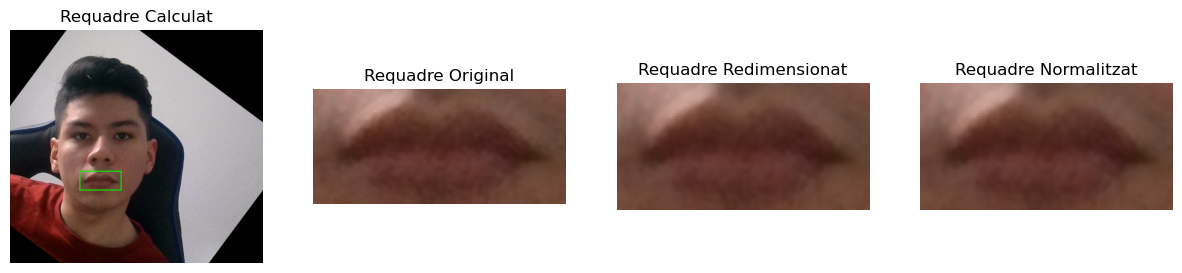

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title('Requadre Calculat')

axes[1].imshow(cv2.cvtColor(cuadrado, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title('Requadre Original')

axes[2].imshow(cv2.cvtColor(imagen_redimensionada, cv2.COLOR_BGR2RGB))
axes[2].axis('off')
axes[2].set_title('Requadre Redimensionat')

axes[3].imshow(cv2.cvtColor(imagen_normalizada, cv2.COLOR_BGR2RGB))
axes[3].axis('off')
axes[3].set_title('Requadre Normalitzat')


# Creació de les noves imatges

Cal recalcar que vaig modificar el meu codi perquè no consumeixi molta memòria, ja que al principi sempre se m'emplenava la memòria i no aconseguia crear un nou conjunt d'imatges.

In [3]:
def extract_lips_rectangle(image, face_mesh):
    lip_info = []
    lip_rect = None
    
    # Procesar la imagen con Face Mesh
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    # Verificar si se detectaron puntos clave
    if results.multi_face_landmarks:
        # Obtener los puntos clave de los labios
        face_landmarks = results.multi_face_landmarks[0]
        for idx in index_lips:
            lip_info.append([face_landmarks.landmark[idx].x * image.shape[1], 
                             face_landmarks.landmark[idx].y * image.shape[0]])
        
        # Calcular el rectángulo que contiene los puntos clave de los labios
        x_min = int(min(point[0] for point in lip_info)) # Un juego de margen para tener más perspectiva de la boca
        y_min = int(min(point[1] for point in lip_info)) 
        x_max = int(max(point[0] for point in lip_info)) 
        y_max = int(max(point[1] for point in lip_info)) 

        box_length_x_margin = int(((x_max - x_min)/100)*20) #Calculamos el 10% de la longitud x de la caja que contiene la boca
        box_length_y_margin = int(((y_max - y_min)/100)*20)

        x_min = x_min - box_length_x_margin
        y_min = y_min - box_length_y_margin
        x_max = x_max + box_length_x_margin 
        y_max = y_max + box_length_y_margin
        
        lip_rect = (x_min, y_min, x_max, y_max)
    
    return lip_rect

def procesar_imagenes(carpeta_principal, path_destino, inicio_cont):
    mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
    cont = inicio_cont
    for entrada in os.listdir(carpeta_principal):
        ruta_absoluta = os.path.join(carpeta_principal, entrada)
        image = cv2.imread(ruta_absoluta)
        reactangle_image = extract_lips_rectangle(image, mp_face_mesh)

        mouth_extract = image[reactangle_image[1]:reactangle_image[3], reactangle_image[0]:reactangle_image[2]]
        mouth_extract_resize = cv2.resize(mouth_extract, (50, 100), interpolation=cv2.INTER_AREA)
        mouth_extract_resize_norm = mouth_extract_resize.astype('float32') / 255.0
        mouth_extract_resize_uint8 = (mouth_extract_resize_norm * 255).astype('uint8')
        
        if mouth_extract is not None:
            cv2.imwrite(path_destino + 'IMG_%06d.jpg' % cont, mouth_extract_resize_uint8)
            cont += 1
        else:
            print("No se pudo alinear la cara en la imagen:", entrada)
    return cont

carpeta_principal = 'img_rotate_lipread_demo/'
path_destino = 'img_LSTM/'
inicio_cont = 0

inicio_cont = procesar_imagenes(carpeta_principal, path_destino, inicio_cont)